In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import AdaBoostClassifier
# from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification

Estimator 1/250, err=0.316436, alpha=0.096275, train_acc=0.6836
Estimator 2/250, err=0.332390, alpha=0.087174, train_acc=0.6836
Estimator 3/250, err=0.340357, alpha=0.082713, train_acc=0.7020
Estimator 4/250, err=0.361322, alpha=0.071204, train_acc=0.7020
Estimator 5/250, err=0.349808, alpha=0.077485, train_acc=0.7266
Estimator 6/250, err=0.374865, alpha=0.063925, train_acc=0.6989
Estimator 7/250, err=0.370958, alpha=0.066013, train_acc=0.7281
Estimator 8/250, err=0.380120, alpha=0.061130, train_acc=0.7281
Estimator 9/250, err=0.386469, alpha=0.057773, train_acc=0.7296
Estimator 10/250, err=0.391051, alpha=0.055362, train_acc=0.7281
Estimator 11/250, err=0.398374, alpha=0.051531, train_acc=0.7281
Estimator 12/250, err=0.397766, alpha=0.051848, train_acc=0.7296
Estimator 13/250, err=0.404175, alpha=0.048512, train_acc=0.7296
Estimator 14/250, err=0.413778, alpha=0.043546, train_acc=0.7281
Estimator 15/250, err=0.407237, alpha=0.046925, train_acc=0.7296
Estimator 16/250, err=0.414719, al

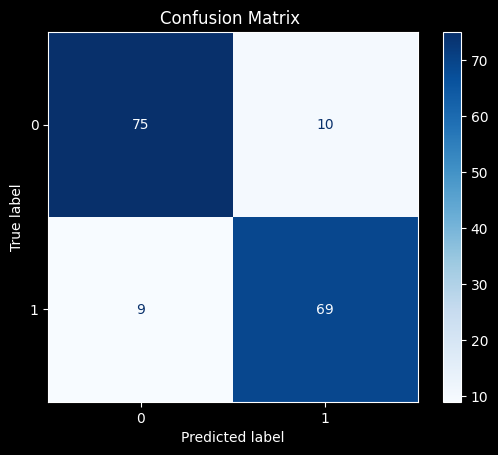

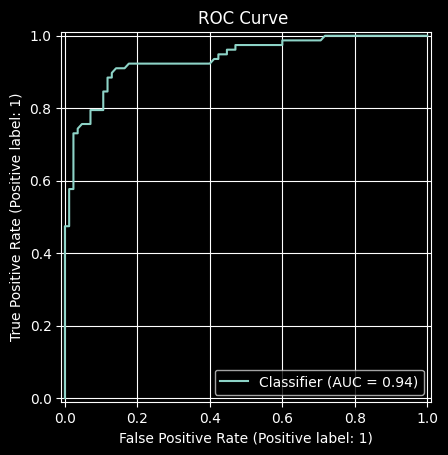

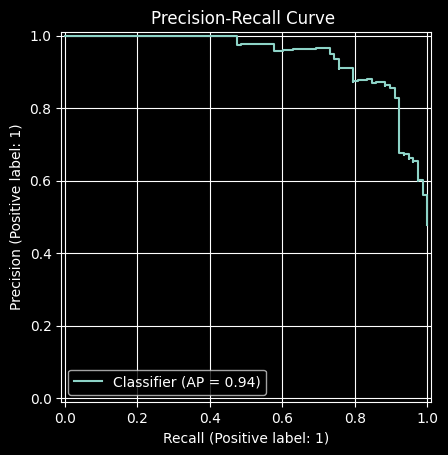

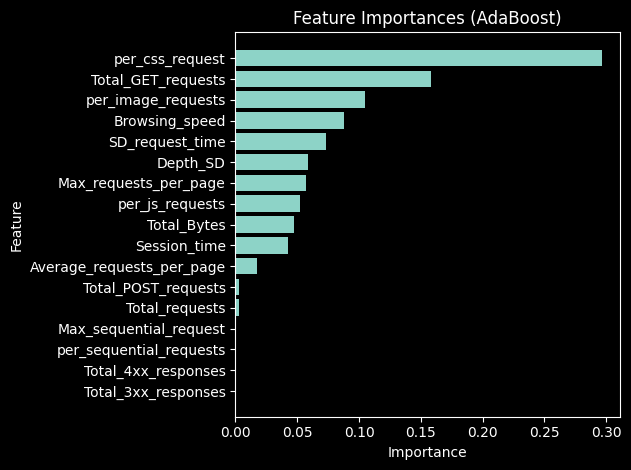

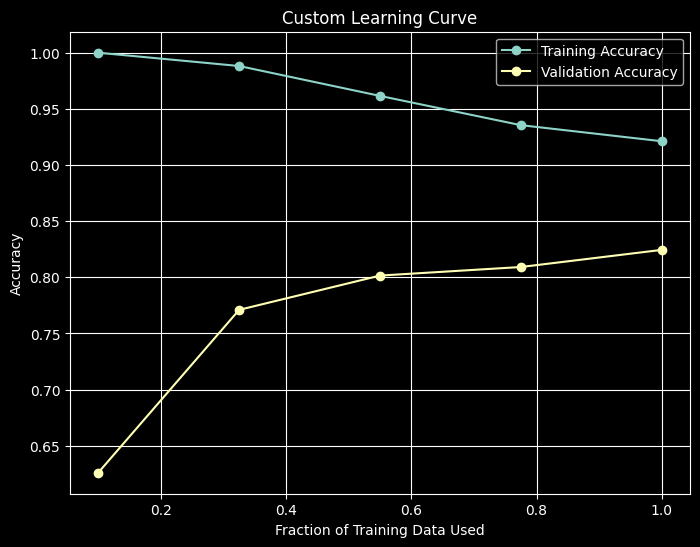

In [ ]:





from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    confusion_matrix,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    PrecisionRecallDisplay,
)
class DecisionStump:
    """
    A simple decision stump: splits on 1 feature with threshold and polarity.
    Predicts labels in {-1, +1}.
    """
    def __init__(self, feature_index=None, threshold=None, polarity=1):
        self.feature_index = feature_index
        self.threshold = threshold
        self.polarity = polarity  # 1 or -1
    
    def predict(self, X):
        # X: numpy array shape (n_samples, n_features)
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        f = X[:, self.feature_index]
        # polarity = 1 => predict +1 when f <= threshold else -1
        preds = np.ones(f.shape[0], dtype=int)
        if self.polarity == 1:
            preds[f > self.threshold] = -1
        else:
            preds[f <= self.threshold] = -1
        return preds


from sklearn.model_selection import learning_curve
from sklearn.base import BaseEstimator, ClassifierMixin

class CustomAdaBoost(BaseEstimator, ClassifierMixin):
    """
    AdaBoost from scratch using decision stumps (1-level thresholds).
    - Works for binary classification. y can be {0,1} or {-1,1} etc.
    - Exposes plotting and reporting utilities.
    """
    def __init__(self, n_estimators=50, learning_rate=1.0, random_state=None):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.random_state = random_state
        self.stumps = []        # list of DecisionStump
        self.alphas = []        # alpha for each stump
        self.feature_importances_ = None
        self.train_scores_ = [] # accuracy over iterations (training)
        self.val_scores_ = []   # optional validation scores
        if random_state is not None:
            np.random.seed(random_state)

    def _prepare_inputs(self, X, y):
        # Accept pandas DataFrame/Series or numpy arrays
        if isinstance(X, pd.DataFrame) or isinstance(X, pd.Series):
            X = X.values
        if isinstance(y, (pd.Series, pd.DataFrame)):
            y = y.values.ravel()
        X = np.asarray(X)
        y = np.asarray(y).ravel()
        # Convert labels to {-1, +1}
        unique = np.unique(y)
        if set(unique) <= {0, 1}:
            y_trans = np.where(y == 0, -1, 1)
        elif set(unique) <= {-1, 1}:
            y_trans = y
        else:
            # map first unique to -1, others to +1 (assumes binary)
            mapping = {unique[0]: -1, unique[1]: 1}
            y_trans = np.vectorize(mapping.get)(y)
        return X, y_trans

    def _best_stump(self, X, y, sample_weights):
        """
        Find best decision stump on X minimizing weighted classification error.
        Returns (best_stump, best_error, best_pred)
        """
        n_samples, n_features = X.shape
        best_stump = None
        best_error = float("inf")
        best_pred = None

        # For each feature, consider thresholds at midpoints of sorted unique values
        for feature_i in range(n_features):
            values = X[:, feature_i]
            sorted_idx = np.argsort(values)
            sorted_values = values[sorted_idx]
            sorted_y = y[sorted_idx]
            sorted_w = sample_weights[sorted_idx]

            # candidate thresholds: midpoints between unique consecutive values
            uniques = np.unique(sorted_values)
            if uniques.size == 1:
                thresholds = [uniques[0]]
            else:
                thresholds = (uniques[:-1] + uniques[1:]) / 2.0

            for thr in thresholds:
                for polarity in [1, -1]:
                    # Predict: +1 if (polarity == 1 and f <= thr) OR (polarity == -1 and f > thr)
                    preds = np.ones(n_samples, dtype=int)
                    if polarity == 1:
                        preds[values > thr] = -1
                    else:
                        preds[values <= thr] = -1
                    # Weighted error: sum w_i * I(pred_i != y_i)
                    mis = (preds != y).astype(float)
                    err = np.dot(sample_weights, mis)
                    if err < best_error:
                        best_error = err
                        best_stump = DecisionStump(feature_index=feature_i, threshold=thr, polarity=polarity)
                        best_pred = preds.copy()
        return best_stump, best_error, best_pred

    def fit(self, X, y, **fit_params):
        X_val = fit_params.get("X_val", None)
        y_val = fit_params.get("y_val", None)
        verbose = fit_params.get("verbose", True)
        """
        Train AdaBoost.
        X, y: training data (numpy array or pandas)
        X_val, y_val: optional validation set (used only for learning curves)
        """
        X, y = self._prepare_inputs(X, y)
        if X_val is not None and y_val is not None:
            X_val, y_val_trans = self._prepare_inputs(X_val, y_val)
            # store mapping back for evaluation if needed
        n_samples = X.shape[0]
        # initialize weights uniformly
        w = np.ones(n_samples) / n_samples

        self.stumps = []
        self.alphas = []
        self.train_scores_ = []
        self.val_scores_ = []

        for m in range(self.n_estimators):
            stump, err, pred = self._best_stump(X, y, w)

            # Avoid division by zero / degenerate stump
            eps = 1e-10
            err = max(eps, min(err, 1 - eps))

            # alpha (classifier weight)
            alpha = self.learning_rate * 0.5 * np.log((1 - err) / err)

            # update weights
            # w_i <- w_i * exp(-alpha * y_i * h_m(x_i))
            w = w * np.exp(-alpha * y * pred)
            w = w / np.sum(w)

            # store
            self.stumps.append(stump)
            self.alphas.append(alpha)

            # training score with current ensemble
            y_scores = self.decision_function(X)  # aggregated score
            y_pred = np.where(y_scores >= 0, 1, -1)
            train_acc = np.mean(y_pred == y)
            self.train_scores_.append(train_acc)

            if X_val is not None and y_val is not None:
                val_scores = self.decision_function(X_val)
                val_pred = np.where(val_scores >= 0, 1, -1)
                # convert y_val_trans back to same representation
                val_acc = np.mean(val_pred == y_val_trans)
                self.val_scores_.append(val_acc)

            # early stopping if perfect fit
            if verbose:
                print(f"Estimator {m+1}/{self.n_estimators}, err={err:.6f}, alpha={alpha:.6f}, train_acc={train_acc:.4f}")

            if err <= eps:
                if verbose:
                    print("Stopping early: perfect stump found.")
                break

        # compute feature importance = sum of alphas for stumps splitting on that feature
        n_features = X.shape[1]
        fi = np.zeros(n_features)
        for stump, a in zip(self.stumps, self.alphas):
            fi[stump.feature_index] += abs(a)
        # normalize
        if fi.sum() > 0:
            fi = fi / fi.sum()
        self.feature_importances_ = fi

    def decision_function(self, X):
        """
        Aggregated (signed) score: sum alpha_m * h_m(x).
        Higher -> positive class.
        """
        if isinstance(X, pd.DataFrame) or isinstance(X, pd.Series):
            X = X.values
        X = np.asarray(X)
        n_samples = X.shape[0]
        agg = np.zeros(n_samples, dtype=float)
        for stump, alpha in zip(self.stumps, self.alphas):
            preds = stump.predict(X)  # in {-1, +1}
            agg += alpha * preds
        return agg

    def predict(self, X):
        """
        Final class labels in original scheme {0,1} if original had {0,1}, otherwise {-1,1}.
        We'll return {0,1} by default (0 for negative, 1 for positive).
        """
        scores = self.decision_function(X)
        preds_signed = np.where(scores >= 0, 1, -1)
        # convert to {0,1} for easier interoperability
        return np.where(preds_signed == -1, 0, 1)

    def predict_proba(self, X):
        """
        Return "score" that can be used for ROC: use aggregated score mapped to [0,1]
        via logistic sigmoid for convenience.
        """
        scores = self.decision_function(X)
        # sigmoid
        probs = 1 / (1 + np.exp(-2 * scores))  # steeper scaling
        # ensure shape (n_samples, 2) similar to sklearn's proba
        probs_2col = np.vstack([1 - probs, probs]).T
        return probs_2col

    def evaluate(self, y_true, y_pred):
        """
        Print accuracy, precision, recall, f1 and classification report.
        Accepts y_true and y_pred as 0/1 or pandas series.
        """
        if isinstance(y_true, (pd.Series, pd.DataFrame)):
            y_true = y_true.values.ravel()
        if isinstance(y_pred, (pd.Series, pd.DataFrame)):
            y_pred = y_pred.values.ravel()
        acc = accuracy_score(y_true, y_pred)
        prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)
        if(f1>0.86):
            print("*********")
        print("====== Evaluation ======")
        print(f"Accuracy : {acc:.6f}")
        print(f"Precision: {prec:.6f}")
        print(f"Recall   : {rec:.6f}")
        print(f"F1-score : {f1:.6f}")
        print("\nClassification Report:\n")
        print(classification_report(y_true, y_pred, zero_division=0))
        return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1}

    def plot_confusion_matrix(self, y_true, y_pred, labels=[0, 1], cmap='Blues'):
        """Plot confusion matrix using sklearn's built-in display."""
        cm = confusion_matrix(y_true, y_pred, labels=labels)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
        disp.plot(cmap=cmap, colorbar=True)
        plt.title("Confusion Matrix ")
        plt.show()

    def plot_roc_pr(self, y_true, X_scores=None):
        """Plot ROC and Precision-Recall curves using sklearn’s built-in functions."""
        if X_scores is None:
            raise ValueError("Provide either X (features) to compute scores or pass precomputed scores.")
        if isinstance(X_scores, (pd.DataFrame, pd.Series)) or (
            isinstance(X_scores, np.ndarray) and X_scores.ndim == 2
        ):
            y_score = self.decision_function(X_scores)
        else:
            y_score = np.asarray(X_scores).ravel()

        # ROC Curve
        RocCurveDisplay.from_predictions(y_true, y_score)
        plt.title("ROC Curve ")
        plt.grid(True)
        plt.show()

        # Precision-Recall Curve
        PrecisionRecallDisplay.from_predictions(y_true, y_score)
        plt.title("Precision-Recall Curve ")
        plt.grid(True)
        plt.show()

    def plot_feature_importance(self, feature_names=None, top_n=None):
        """Use built-in bar plot for feature importances (still manual, sklearn doesn't have one for AdaBoost)."""
        fi = self.feature_importances_
        if fi is None:
            raise RuntimeError("Feature importances not computed. Call fit() first.")
        n_features = fi.shape[0]
        if feature_names is None:
            feature_names = [f"Feature {i}" for i in range(n_features)]
        idx = np.argsort(fi)[::-1]
        if top_n:
            idx = idx[:top_n]

        plt.barh(range(len(idx)), fi[idx])
        plt.yticks(range(len(idx)), [feature_names[i] for i in idx])
        plt.xlabel("Importance")
        plt.ylabel("Feature")
        plt.title("Feature Importances (AdaBoost)")
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

    def plot_learning_curve_custom(self, X, y, train_sizes=None, test_size=0.2, random_state=42):
        """
        Custom learning curve plot that does not rely on sklearn.learning_curve.
        Works even if the estimator has custom fit() parameters.
        """
        if train_sizes is None:
            train_sizes = np.linspace(0.1, 1.0, 5)

        X = np.array(X)
        y = np.array(y)

        train_scores = []
        test_scores = []

        for frac in train_sizes:
            # Split data manually
            X_train_part, X_val_part, y_train_part, y_val_part = train_test_split(
                X, y, test_size=test_size, random_state=random_state
            )

            n_train = int(len(X_train_part) * frac)
            X_sub, y_sub = X_train_part[:n_train], y_train_part[:n_train]

            # Fit model (use the same signature your model expects)
            self.fit(X_sub, y_sub, verbose=False)

            # Compute scores
            y_train_pred = self.predict(X_sub)
            y_val_pred = self.predict(X_val_part)

            train_acc = accuracy_score(y_sub, y_train_pred)
            val_acc = accuracy_score(y_val_part, y_val_pred)

            train_scores.append(train_acc)
            test_scores.append(val_acc)

        # --- Plot ---
        plt.figure(figsize=(8, 6))
        plt.plot(train_sizes, train_scores, "o-", label="Training Accuracy")
        plt.plot(train_sizes, test_scores, "o-", label="Validation Accuracy")
        plt.xlabel("Fraction of Training Data Used")
        plt.ylabel("Accuracy")
        plt.title("Custom Learning Curve")
        plt.legend()
        plt.grid(True)
        plt.show()
    
    def score(self, X, y):
        """Return accuracy score (required for sklearn compatibility)."""
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)

    def full_report(self, X_train, y_train, X_test, y_test, show_plots=True):
        """
        Evaluate model on test set and print metrics + show plots.
        """
        y_pred = self.predict(X_test)
        self.evaluate(y_test, y_pred)
        if show_plots:
            self.plot_confusion_matrix(y_test, y_pred)
            # ROC/PR - pass features to compute scores
            self.plot_roc_pr(y_test, X_scores=X_test)
            self.plot_feature_importance()
        return y_pred



def run_test():
    df_bots = pd.read_csv("../parsed_data/bots.csv")
    df_bots["bot"] = 1
    df_bots

    df_hum = pd.read_csv("../parsed_data/human.csv")
    df_hum["bot"] = 0
    df_hum
    df_merged = pd.concat([df_bots, df_hum], ignore_index=True, sort=False)
    df_merged
    X = df_merged.iloc[:, 1:-1].values
    Y = df_merged.iloc[:, -1].values
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # assume X_train, y_train, X_test, y_test are already prepared (numpy arrays or pandas)
    list_of_feature_names = df_hum.columns[1:].tolist()
    # print(list_of_feature_names)

    # best f1-score for pairs {n-estimators,learning_rate} = [{175,0.5}, {250,0.25}] -> bots.csv & humans.csv 
    # best f1-score for pair {n-estimators,learning_rate} = [{100,0.25}] -> bots.csv & humans.csv 

    n_estimators = [250]
    learning_rates = [0.25]

    for n_estimator,learning_Rate in zip(n_estimators,learning_rates):
        # print(n_estimator,learning_Rate)
        model=CustomAdaBoost(n_estimators=n_estimator,learning_rate=learning_Rate,random_state=42)

        # optional: pass a validation split to get validation learning curve points
        model.fit(X_train, y_train, X_val=X_test, y_val=y_test, verbose=True)

        # predictions
        y_pred = model.predict(X_test)
        probas = model.predict_proba(X_test)[:, 1]  # probability of positive

        # evaluation printed
        model.evaluate(y_test, y_pred)

        # plots (printed inline)
        model.plot_confusion_matrix(y_test, y_pred)
        y_scores = model.decision_function(X_test)
        model.plot_roc_pr(y_test, X_scores=y_scores)
        model.plot_feature_importance(feature_names=list_of_feature_names)
        model.plot_learning_curve_custom(X_train, y_train)


